---
# VisionSpace Challenge
---
### Description
This Notebook includes all solutions and explainations of all three challenges.
### Requierements
The following cell installs all packages that I used to solve the tasks.
*TODO: Explain the packages*




In [ ]:
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install tensorflow 
%pip install scikit-learn

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
#from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from src.data import *

# Challenge I
---
## Desciption
The Janus satellite provides information that supports ground exploration missions on Mars. A sample
of the dataset in .csv format and a short description of its columns can be found in this repository:
https://github.com/visionspacetec/ai-interview-challanges
Your goal is to apply Machine Learning techniques to predict Janus’ power consumption.
## Solution
Assumption: As the exact predition goal is not further specified, I set it to a next-hour prediction, this also aligns well with real-time monitoring needs and can be helpful to determine anomalies. Another possibility would be to predict the next 24-hour profile which would be useful for battery planning or solar panel alignment. I decided against this goal as the data set includes only around 20 days and therefore such a prediciton would be really challenging because there might be long-term trends or periodic variations that are not captured by the data.

In [2]:
current_dir_path = os.getcwd()
data_file_path = os.path.join(current_dir_path, 'SatelliteDataSet.csv')

df = pd.read_csv(data_file_path)

# features = ["power", 
#             "sa", 
#             "sx", "sy", "sz", "sunmars_km", 
#             "earthmars_km", "sunmarsearthangle_deg", 
#             "solarconstantmars", 
#             "eclipseduration_min", 
#             "occultationduration_min", "flagcomms"]

features = ["power", "sunmars_km", 
             "earthmars_km", "sunmarsearthangle_deg", 
             "solarconstantmars", 
             "eclipseduration_min", 
             "occultationduration_min",
             "ACROSS_TRACK", "NADIR",
             "D1PVMC", "EARTH","MAINTENANCE"
             ]

#All features
#features = ["power", "sa", "sx", "sy", "sz", "sunmars_km", 
#            "earthmars_km", "sunmarsearthangle_deg", 
#            "solarconstantmars", "eclipseduration_min", 
#            "occultationduration_min", "flagcomms", 
#            "ACROSS_TRACK", "D1PVMC", "D4PNPO", "EARTH", "INERTIAL",
#            "MAINTENANCE", "NADIR", "RADIO_SCIENCE", "SLEW", "WARMUP"]

target = "power"

# Data Engineering


In [3]:
# Compute correlation of power consumption with each event
#for event in ["ACROSS_TRACK", "D1PVMC", "D4PNPO", "EARTH", "INERTIAL", "MAINTENANCE", "NADIR", "RADIO_SCIENCE", "SLEW", "WARMUP"]:
#    event_correlations = df['power'].corr(df[event])
#    print(event, "corr:", event_correlations)

for event in ["sa", 
             "sx", "sy", "sz", "sunmars_km", 
             "earthmars_km", "sunmarsearthangle_deg", 
             "solarconstantmars", 
             "eclipseduration_min", 
             "occultationduration_min", "flagcomms"]:
    event_correlations = df['power'].corr(df[event])
    print(event, "corr:", event_correlations)

sa corr: -0.020544560234196263
sx corr: -0.06295831848175014
sy corr: 0.04444490970557691
sz corr: -0.020810284280368536
sunmars_km corr: 0.19974244640596475
earthmars_km corr: -0.20639710818444582
sunmarsearthangle_deg corr: 0.2012390740042775
solarconstantmars corr: -0.19919449142335285
eclipseduration_min corr: 0.09782691747868208
occultationduration_min corr: 0.19605991498185174
flagcomms corr: -0.014790854659758542


In [3]:
# Derived Features: 5-hour mean, day hour, effective solar power, check which commands have impact on power

df['power_mean_3h'] = df['power'].rolling(window=3, min_periods=1).mean()
features.append("power_mean_5h")

df['power_mean_5h'] = df['power'].rolling(window=5, min_periods=1).mean()
features.append("power_mean_5h")

#df['ut_ms'] = pd.to_datetime(df['ut_ms'], format='%Y-%m-%d %H:%M:%S')
#df['hour_of_day'] = df['ut_ms'].dt.hour
#features.append('hour_of_day')
#
#df["sa"] = df["sa"].apply(np.deg2rad).apply(np.cos)
#df['solar_power'] = df['sa'] * df['solarconstantmars']
#features.append('solar_power')

# Apply trigonomic function to degree
#df[["sunmarsearthangle_deg"]] = df[["sunmarsearthangle_deg"]].apply(np.deg2rad).apply(np.sin)

# Scale features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [13]:
for event in ["power_mean_5h", "hour_of_day", 'solar_power']:
    event_correlations = df['power'].corr(df[event])
    print(event, "corr:", event_correlations)

power_mean_5h corr: 0.5454291384882906
hour_of_day corr: 0.006145589493384973
solar_power corr: -0.19919451910929586


In [4]:
data_values = df[features].values

sequence_lenght = 2

x, y = create_sequences(data_values, target_column=features.index(target), sequence_length=sequence_lenght)

train_val_split = 0.8

train_size = int(len(x)*train_val_split)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Training LSTM

In [5]:
stop_training = EarlyStopping(monitor='val_loss', patience=20)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),# TODO check parameters
    Dropout(0.5),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(25, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(x_train, y_train, epochs=200, batch_size=12, validation_data=(x_test, y_test), 
                    callbacks=[stop_training], 
                    verbose=1)

Epoch 1/200


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1377 - mae: 0.3102 - val_loss: 0.0491 - val_mae: 0.1929
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - mae: 0.1787 - val_loss: 0.0481 - val_mae: 0.1896
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0442 - mae: 0.1739 - val_loss: 0.0475 - val_mae: 0.1872
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395 - mae: 0.1635 - val_loss: 0.0473 - val_mae: 0.1854
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416 - mae: 0.1674 - val_loss: 0.0467 - val_mae: 0.1847
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0411 - mae: 0.1662 - val_loss: 0.0486 - val_mae: 0.1851
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0398 - mae: 0.1690 - val_loss: 0.0508 - val_mae: 0.1864
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410 - mae: 0.1621 - val_loss: 0.0501 - val_mae: 0.1855
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338 - mae: 0.1

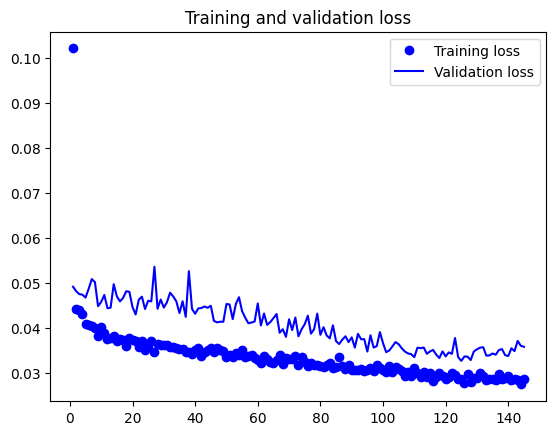

In [6]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#mean_absolute_error = history.history['val_mae']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

#plt.plot(epochs, mean_absolute_error, '--', label='Mean absolute error')

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


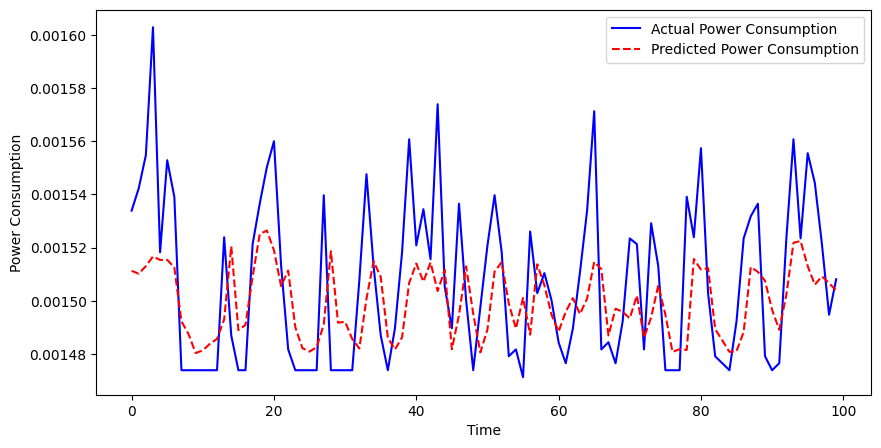

In [7]:
y_pred = model.predict(x_test)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()]*len(features)))[:, 0]

plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled, label="Actual Power Consumption", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Power Consumption", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

In [8]:
# Baseline
power_values = df[['power']].values
power_values_scaled = scaler.fit_transform(power_values)

y_baseline = power_values_scaled[(sequence_lenght-1):]

y_train_baseline, y_test_baseline = y_baseline[:train_size], y_baseline[train_size:-1]


baseline_model = Sequential([
    Flatten(input_shape=(x_train.shape[1], x_train.shape[2])), # TODO:Check flatten
    Dense(1)
])

baseline_model.compile(optimizer="adam", loss='mse', metrics=["mae"])

baseline_history = baseline_model.fit(x_train, y_train_baseline,
                                      epochs=100, batch_size=16,
                                      validation_data=(x_test, y_test_baseline),
                                      callbacks=[stop_training],  verbose=1)


Epoch 1/100


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7566 - mae: 0.8011 - val_loss: 1.1687 - val_mae: 1.0301
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4315 - mae: 0.5742 - val_loss: 0.8178 - val_mae: 0.8441
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2503 - mae: 0.4256 - val_loss: 0.5921 - val_mae: 0.7007
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2049 - mae: 0.3736 - val_loss: 0.4525 - val_mae: 0.5971
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1365 - mae: 0.2992 - val_loss: 0.3759 - val_mae: 0.5342
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1366 - mae: 0.2986 - val_loss: 0.3277 - val_mae: 0.4957
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1269 - mae: 0.2839 - val_loss: 0.2884 - val_mae: 0.4624
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1116 - mae: 0.2631 - val_loss: 0.2551 - val_mae: 0.4333
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1069 - mae: 0.2

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


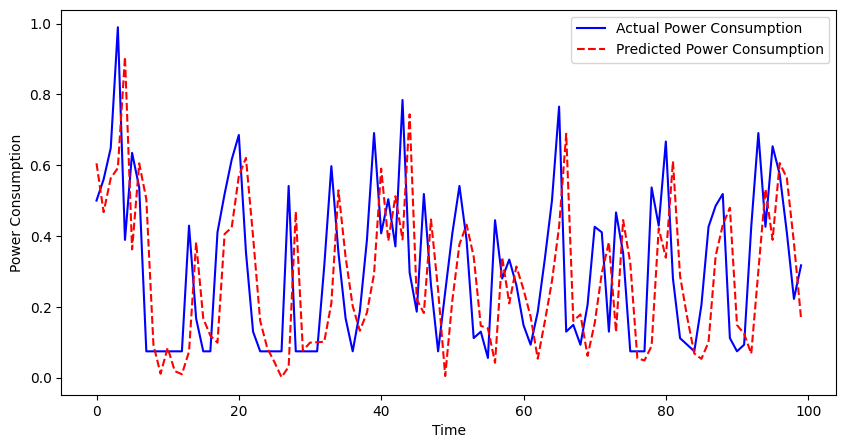

In [9]:
y_baseline_pred = baseline_model.predict(x_test)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]


plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled, label="Actual Power Consumption", color="blue")
plt.plot(y_baseline_pred_rescaled, label="Predicted Power Consumption", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

In [10]:
# Performance comparision

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()]*len(features)))[:, 0]

mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

mae_baseline = mean_absolute_error(y_test_rescaled, y_baseline_pred_rescaled)
rmse_baseline = np.sqrt(mean_squared_error(y_test_rescaled, y_baseline_pred_rescaled))

print(f"LSTM Model: MAE = {mae_lstm:.4f}, RMSE = {rmse_lstm:.4f}")
print(f"Baseline Model: MAE = {mae_baseline:.4f}, RMSE = {rmse_baseline:.4f}")

mae_improvement = (mae_baseline - mae_lstm) / mae_baseline * 100
rmse_improvement = (rmse_baseline - rmse_lstm) / rmse_baseline * 100

print(f"MAE improvement: {mae_improvement:.2f} %")
print(f"RMSE improvement: {rmse_improvement:.2f} %")

#plt.figure(figsize=(12, 6))
#
#plt.plot(y_test_rescaled, label="Actual Power Consumption", color="blue")
#plt.plot(y_pred_rescaled, label="LSTM Prediction", color="green", linestyle="dashed")
#plt.plot(y_baseline_pred_rescaled, label="Baseline Prediction", color="red", linestyle="dotted")
#
#plt.xlabel("Time Steps")
#plt.ylabel("Power Consumption")
#plt.title("Comparison of LSTM and Baseline Predictions")
#plt.legend()
#plt.show()

LSTM Model: MAE = 0.1503, RMSE = 0.1891
Baseline Model: MAE = 0.1806, RMSE = 0.2278
MAE improvement: 16.73 %
RMSE improvement: 16.99 %
